In [2]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,random_split
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from tensorflow import keras
import tensorflow as tf
import warnings

warnings.filterwarnings('ignore')

In [3]:
import zipfile
import os

zip_file_path = "/kaggle/input/gan-introduction/images.zip"

# Define the directory where you want to extract the files
extract_to_directory = "/kaggle/working/images"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents of the zip file to the specified directory
    zip_ref.extractall(extract_to_directory)

print("Extraction complete.")


Extraction complete.


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
image_dir = '/kaggle/working/images'

# Get the list of all image paths
image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir)]
print(f"Total images: {len(image_paths)}")

Total images: 10000


In [6]:
img_size = 64
batch_size = 32
buffer_size = 20000


In [7]:
manual_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


print(f"Manually created Transform : {manual_transform}")

Manually created Transform : Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=(0.5,), std=(0.5,))
)


In [8]:
from torch.utils.data import DataLoader, Dataset
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        # Convert (C, H, W) to (H, W, C)
        image = image.permute(1, 2, 0)
        return image


In [9]:
NUM_WORKERS = os.cpu_count()

def create_dataloader(
    image_paths: list,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int = NUM_WORKERS
):
    data = CustomImageDataset(image_paths, transform=transform)
    data_loader = DataLoader(
        data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    return data_loader

In [10]:
image_dir = '/kaggle/working/images'
image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir)]
sample_img_path = image_paths[0]
print(f"Trying to load image: {sample_img_path}")

Trying to load image: /kaggle/working/images/image_09818.png


Image tensor shape: torch.Size([3, 64, 64])


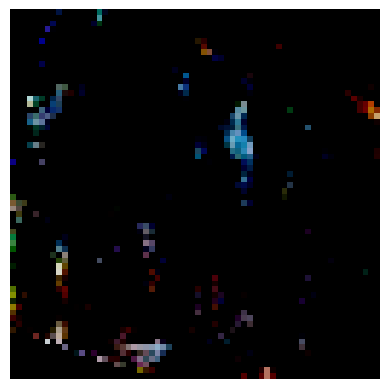

In [11]:
from PIL import Image
import matplotlib.pyplot as plt

try:
    sample_img = Image.open(sample_img_path).convert('RGB')
except Exception as e:
    print(f"Error: {e}")
else:
    sample_img_tensor = manual_transform(sample_img)
    print(f"Image tensor shape: {sample_img_tensor.shape}")
    
    # Display the image using matplotlib
    plt.imshow(sample_img_tensor.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

In [12]:
data_loader = create_dataloader(image_paths, manual_transform, batch_size, NUM_WORKERS)

# Iterate over a few batches of data
for batch_idx, images in enumerate(data_loader):
    print(f"Batch {batch_idx+1} - Images shape: {images.shape}")

Batch 1 - Images shape: torch.Size([32, 64, 64, 3])
Batch 2 - Images shape: torch.Size([32, 64, 64, 3])
Batch 3 - Images shape: torch.Size([32, 64, 64, 3])
Batch 4 - Images shape: torch.Size([32, 64, 64, 3])
Batch 5 - Images shape: torch.Size([32, 64, 64, 3])
Batch 6 - Images shape: torch.Size([32, 64, 64, 3])
Batch 7 - Images shape: torch.Size([32, 64, 64, 3])
Batch 8 - Images shape: torch.Size([32, 64, 64, 3])
Batch 9 - Images shape: torch.Size([32, 64, 64, 3])
Batch 10 - Images shape: torch.Size([32, 64, 64, 3])
Batch 11 - Images shape: torch.Size([32, 64, 64, 3])
Batch 12 - Images shape: torch.Size([32, 64, 64, 3])
Batch 13 - Images shape: torch.Size([32, 64, 64, 3])
Batch 14 - Images shape: torch.Size([32, 64, 64, 3])
Batch 15 - Images shape: torch.Size([32, 64, 64, 3])
Batch 16 - Images shape: torch.Size([32, 64, 64, 3])
Batch 17 - Images shape: torch.Size([32, 64, 64, 3])
Batch 18 - Images shape: torch.Size([32, 64, 64, 3])
Batch 19 - Images shape: torch.Size([32, 64, 64, 3])
Ba

### **UPSAMPLING**

In [1]:
from tensorflow.keras import layers
def make_generator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256), f"Expected (None, 8, 8, 256) but got {model.output_shape}"
    
    # First Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 256), f"Expected (None, 8, 8, 256) but got {model.output_shape}"
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Second Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128), f"Expected (None, 16, 16, 128) but got {model.output_shape}"
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Third Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64), f"Expected (None, 32, 32, 64) but got {model.output_shape}"
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Output Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3), f"Expected (None, 64, 64, 3) but got {model.output_shape}"
    
    return model

generator = make_generator_model()
generator.summary()

2024-05-27 14:47:32.817904: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-27 14:47:32.820371: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-27 14:47:32.913786: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-27 14:47:33.279711: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 14:47:34.468677: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

NameError: name 'tf' is not defined

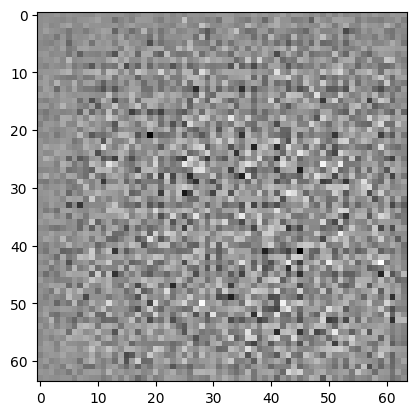

In [14]:
generator = make_generator_model()

noise = tf.random.normal([1, 100]) #latent space
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### **DOWNSAMPLING**

In [15]:
# Downsampling from 32×32 to 16×16, then to 8×8, before the model makes an output prediction

def make_discriminator_model():
    model = tf.keras.Sequential()
    
    # First Conv2D layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Second Conv2D layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Third Conv2D layer
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Flatten the output and add a dense layer with sigmoid activation for binary classification
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │        16,385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,045,633 (3.99 MB)

 Trainable params: 1,045,633 (3.99 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.49989358]], shape=(1, 1), dtype=float32)


## Let us Define LOSS for Generator and Discrminator

In [17]:
# Defining the loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## **Discriminator loss** -- iscriminator is able to distinguish real images from fakes.

In [18]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

## **Generator loss**  -- trick the discriminator.


In [19]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [20]:
# we are using Adam optimizer here for faster convergence

gen_opt = tf.keras.optimizers.Adam(1e-4)
disc_opt = tf.keras.optimizers.Adam(1e-4)

**Save checkpoints**
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [21]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=gen_opt,
                                 discriminator_optimizer=disc_opt,
                                 generator=generator,
                                 discriminator=discriminator)

## **Training**

In [22]:
EPOCHS = 32
noise_dim = 100
num_examples_to_generate = 16

# Generating Noise:
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [27]:
@tf.function  # compiling and optimizing
def train_steps(images):
    noise = tf.random.normal([batch_size,noise_dim])
    
    # Here we use Gradient_tape for both Generator and Discriminator for Gradient production
    with tf.GradientTape() as Generator_tape , tf.GradientTape() as Discrminator_tape:
        generated_images = generator(noise,training=True)
        
        real_output = discriminator(images,training=True)
        fake_output = discriminator(generated_images,training=True)
        
        # loss
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output,fake_output)
        
    grad_of_gen = Generator_tape.gradient(gen_loss,generator.trainable_variables)
    grad_of_disc = Discrminator_tape.gradient(disc_loss,discriminator.trainable_variables)
    
    # optimizers
    
    gen_opt.apply_gradients(zip(grad_of_gen,generator.trainable_variables))
    disc_opt.apply_gradients(zip(grad_of_disc,discriminator.trainable_variables))
    
    real_accuracy = tf.reduce_mean(tf.cast(tf.greater(real_output, 0.5), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.less(fake_output, 0.5), tf.float32))
    disc_accuracy = (real_accuracy + fake_accuracy) / 2.0
    
    return gen_loss, disc_loss, disc_accuracy

### **Above code is to generate fake and real images**

In [28]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

### **Below code is for training Gen and Disc**

In [30]:
from IPython import display
import time

def train(dataset, epochs):
    gen_losses = []
    disc_losses = []
    disc_accuracies = []

    for epoch in range(epochs):
        start = time.time()
        
        total_gen_loss = 0
        total_disc_loss = 0
        total_disc_accuracy = 0
        num_batches = 0
        
        for image_batch in dataset:
            gen_loss, disc_loss, disc_accuracy = train_steps(image_batch)
            total_gen_loss += gen_loss
            total_disc_loss += disc_loss
            total_disc_accuracy += disc_accuracy
            num_batches += 1
        
        avg_gen_loss = total_gen_loss / num_batches
        avg_disc_loss = total_disc_loss / num_batches
        avg_disc_accuracy = total_disc_accuracy / num_batches
        
        # Append losses and accuracy to the lists
        gen_losses.append(avg_gen_loss)
        disc_losses.append(avg_disc_loss)
        disc_accuracies.append(avg_disc_accuracy)
        
        # Clear the output and generate images
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        
        # Save the model every 10 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        
        # Print the time, losses, and accuracy for the epoch
        print(f'Time for epoch {epoch + 1} is {time.time() - start} sec')
        print(f'Generator loss: {avg_gen_loss:.4f}, Discriminator loss: {avg_disc_loss:.4f}, Discriminator accuracy: {avg_disc_accuracy:.4f}')
    
    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)
    
    # Print final metrics
    print(f'Final Generator loss: {gen_losses[-1]:.4f}')
    print(f'Final Discriminator loss: {disc_losses[-1]:.4f}')
    print(f'Final Discriminator accuracy: {disc_accuracies[-1]:.4f}')




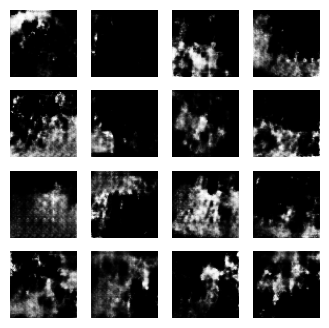

Final Generator loss: 1.9846
Final Discriminator loss: 0.7059
Final Discriminator accuracy: 0.8400


In [31]:
train(data_loader, EPOCHS)

In [32]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [33]:
import PIL
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

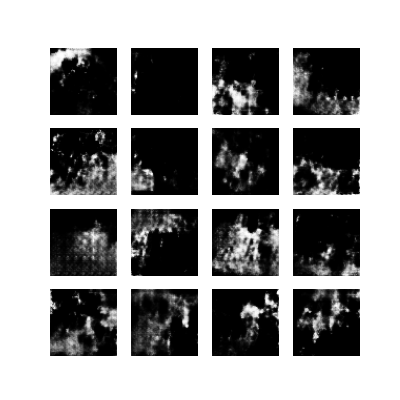

In [34]:
display_image(EPOCHS)